# Band pass filter

One of the critical preprocessing steps in EEG signal analysis is **filtering**. EEG signals are often contaminated with noise and artifacts from various sources, including muscle activity, eye movements, and electrical interference. To isolate the brain's electrical activity of interest, filters are used to remove unwanted frequencies. A band pass filter is particularly useful in EEG signal processing, as it allows frequencies within a specific range to pass through while attenuating frequencies outside this range.

A band-pass filter combines the characteristics of both low-pass and high-pass filters. It allows frequencies within a certain range (the passband) to pass through while rejecting frequencies outside this range. The primary parameters of a band pass filter are:  
**Lower Cutoff Frequency**: The lower bound of the passband.  
**Upper Cutoff Frequency**: The upper bound of the passband.  
**Order of the Filter**: This determines the steepness of the filter's response and its attenuation outside the passband.

In the context of EEG, common frequency bands of interest include:  
**Delta** (0.5-4 Hz): Associated with deep sleep.   
**Theta** (4-8 Hz): Related to drowsiness and meditation.  
**Alpha** (8-13 Hz): Linked to relaxed, wakeful states.  
**Beta** (13-30 Hz): Associated with active thinking and focus.  
**Gamma** (30-100 Hz): Related to high-level cognitive functioning. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import os

In [3]:
data = pd.read_excel('datasets/dataset.xlsx')
data

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8
0,23899.1,2951.1,36442.2,38418.6,12414.9,3759.5,31001.4,52775.3
1,23917.7,3048.0,36463.8,38344.3,12448.1,3726.3,31032.4,52223.4
2,23984.9,3148.2,36525.1,39002.6,12520.4,3601.3,31103.2,53175.1
3,24016.8,3183.3,36551.5,39602.8,12548.5,3473.0,31133.2,54514.6
4,23960.3,3061.0,36494.8,39256.9,12475.6,3549.7,31061.9,54321.3
...,...,...,...,...,...,...,...,...
7115,23896.6,3893.1,37567.5,38276.6,11183.1,4515.5,31611.9,48532.8
7116,23850.2,3780.5,37514.3,38075.4,11119.7,4572.2,31551.9,48566.2
7117,23766.2,3644.2,37432.3,37477.1,11029.8,4755.0,31464.2,47165.5
7118,23768.4,3709.8,37443.6,37362.9,11048.4,4738.0,31481.5,46410.0


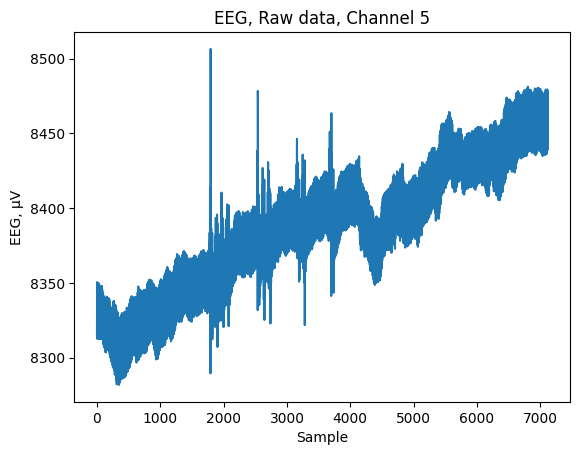

In [28]:
# select the data from the fifth channel
channel = 0
channel_data = data.iloc[:, 6]
# convert from Digital Value of Analog Digital converter (ADC) ADS1299 to microvolts
channel_data = round(1000000*4.5*(channel_data/16777215),2)
# plot the EEG data
plt.plot(channel_data)
plt.title("EEG, Raw data, Channel " +str(channel + 5))
plt.ylabel('EEG, µV')  # Data from ADS1299
plt.xlabel('Sample')
plt.show()

## Signal proccessing

Signal processing for EEG (Electroencephalography) data involves a range of techniques used to analyze and extract meaningful information from the electrical signals recorded from the brain. EEG signals are complex and often contaminated with noise, artifacts, and other unwanted components. Signal processing methods are essential for enhancing the signal quality, identifying patterns, and understanding brain activity.

## Band Pass Filter

Band-pass filtering is a common signal processing technique used in EEG data analysis to isolate specific frequency bands of interest while removing unwanted frequencies. Band-pass filtering allows researchers to focus on particular brainwave rhythms that are relevant to their study. For example, you might want to extract the alpha, beta, or gamma waves from the EEG data. 


**Positive**  

*   Frequency Analysis: EEG signals exhibit various frequency components (e.g., alpha, beta, delta, theta waves), each associated with different cognitive processes. A band-pass filter isolates these components, aiding frequency-specific analysis.

* Event-Related Potentials (ERPs): When studying ERPs or specific neural responses to stimuli, a band-pass filter can highlight the frequency ranges relevant to the event.

* Artifact Removal: Band-pass filters can reduce certain types of artifacts, such as low-frequency drifts or high-frequency noise, by focusing on the desired frequency range.

* Functional Connectivity: Applying consistent band-pass filtering across channels can help enhance functional connectivity analysis by removing frequencies unrelated to the neural network under investigation.

* Removing Baseline Drift: For EEG recordings, slow baseline drifts can obscure meaningful activity. Band-pass filters with cutoffs around the drift frequency can help minimize this effect.

**Negative**

*  While band-pass filters can be valuable for EEG data analysis, they can also be problematic when used inappropriately or excessively. Here are some scenarios where a band-pass filter might not be suitable for EEG processing:

* Overfiltering. Applying overly narrow band-pass filters can lead to signal distortion and the removal of genuine neural activity. Aggressive filtering might result in the loss of important frequency components.

* Misaligned Cutoff Frequencies. Setting incorrect low-pass and high-pass cutoff frequencies can result in unintended filtering of important neural oscillations or event-related potentials.

* Baseline Drift Removal. Relying solely on a band-pass filter to remove baseline drift can inadvertently remove relevant low-frequency neural signals along with the drift.

* Lack of Understanding. If you lack a clear understanding of the frequency characteristics of EEG signals and the implications of filtering, you might misuse band-pass filters and draw incorrect conclusions from your analysis.

* Data Artifacts. Band-pass filtering might not effectively remove certain types of artifacts, such as muscle artifacts or eye blinks, requiring additional preprocessing steps.

* Uneven Spectral Distribution. EEG signals often have uneven spectral distributions, and applying a uniform band-pass filter might not accurately capture the underlying neural activity.

* Inconsistent Filtering. If you apply different band-pass filters to different data segments or channels without justification, it can lead to inconsistencies in your analysis.


**How it works**   
A band-pass filter for EEG works by selectively allowing a specific range of frequencies within the EEG signal to pass through while diminishing frequencies outside that range. This is achieved through a filter design that boosts the desired frequencies and reduces amplitudes of unwanted frequencies, helping highlight neural activity in the chosen frequency band for focused analysis.

Here we use **Butterworth filters** via Scipy library. [signal.butter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html) is a function provided by the [scipy.signal](https://docs.scipy.org/doc/scipy/reference/signal.html) module in Python. It is used to design digital Butterworth filters, which are a type of infinite impulse response (IIR) filter commonly used for signal processing tasks, including filtering EEG signals. The Butterworth filter is characterized by having a flat frequency response in its passband and a gradual roll-off in its stopband.  

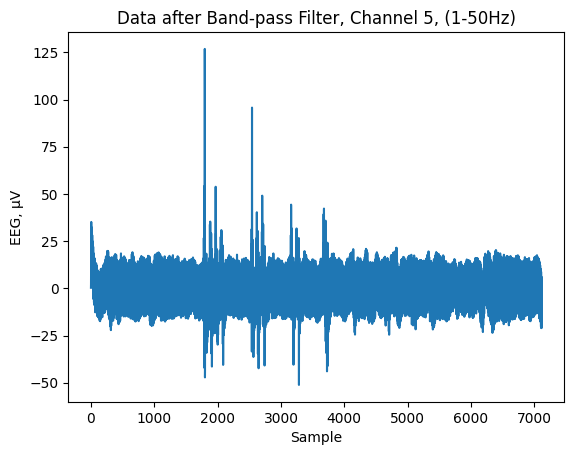

In [22]:
def butter_highpass_filter(data, cutoff, nyq, order=5):
    """Butterworth high-pass filter.
    Args:
        data (array_like): data to be filtered.
        cutoff (float): cutoff frequency.
        order (int): order of the filter.
    Returns:
        array: filtered data."""
    normal_cutoff = cutoff / nyq  # normalized cutoff frequency
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    filtered_data = signal.filtfilt(b, a, data)
    return filtered_data
def butter_lowpass_filter(data, cutoff, nyq, order=5):
    """Butterworth low-pass filter.
    Args:
        data (array_like): data to be filtered.
        cutoff (float): cutoff frequency.
        order (int): order of the filter.
    Returns:
        array: filtered data."""
    normal_cutoff = cutoff / nyq  # normalized cutoff frequency
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = signal.lfilter(b, a, data)
    return filtered_data

channel_data_bp_filtered = channel_data.copy()  # copy the data\
fps = 250  # sampling frequency
cutoff_high = 1  # cutoff frequency of the high-pass filter
cutoff_low = 50  # cutoff frequency of the low-pass filter
nyq = 0.5 * fps  # Nyquist frequency (half of the sampling frequency).  It represents the highest frequency that can be accurately represented in a discrete-time signal.

# apply the band-pass filter
channel_data_bp_filtered = butter_highpass_filter(
    data=channel_data_bp_filtered,
    cutoff=cutoff_high,
    nyq=nyq,
    order=5)
channel_data_bp_filtered = butter_lowpass_filter(
    data=channel_data_bp_filtered,
    cutoff=cutoff_low,
    nyq=nyq,
    order=4)

plt.plot(channel_data_bp_filtered)
plt.title("Data after Band-pass Filter, Channel " +  str(channel+5) +", ("+str(cutoff_high)+"-"+str(cutoff_low) + "Hz)")
plt.ylabel('EEG, µV')
plt.xlabel('Sample')
plt.show()